![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
# QuantConnect Alpha Streams
#### Licensed Under QuantConnect Platform Service Agreement v1.0. Copyright QuantConnect 2018.
#### For more information; see the Open API Specification of Alpha Streams: https://app.swaggerhub.com/apis/QuantConnect/Alpha/0.4

## Introduction

QuantConnect Alpha Streams allows quantiative funds to search a database of algorithm authors; and instantly license the authors' strategies (`Alpha`). The license agreements and fee structure is already prenegotiated, and the standardized backtesting and live trading infrastructure can give funds confidence in the algorithm results. Upon licensing an Alpha the insights/signals are instantly delivered to the fund in realtime.

## Terminology
 - `Alpha`     - Strategy for licensing.
 - `Author`    - QuantConnect member and creator of the Alpha. 
 - `Insight`   - Trade signal from an algorithm; consisting of an asset, direction, magnitude and confidence.
 - `Project`   - Properties of the project which submitted the `Alpha` 

## SDK Demonstration


### 1. Setup the SDK: Login with Client Credentials
We have written a full abstraction and SDK for the API which you can quickly import into your investment process. To start create a new instance of the `AlphaStreamClient` with your clientId and token.

In [1]:
# Prepare the import. This step is needed of AlphaStream is not installed yet\n",
try:
    import AlphaStream
except ImportError:
    import os, sys
    from os.path import dirname
    sys.path.append(dirname(os.getcwd()))

In [2]:
# Import Python SDK Client Library 
from AlphaStream import AlphaStreamRestClient 

# Define the clientId and API access token:
clientId  = "c7bd966e930c4b15b2ec13eb0d6170d9"
token     = "7030e89cfcc1948f4f93e91edd93d6f687c737844a6969d99d609a78f8d0a5c4091ef11f31c4c0e9cccacefe36ff4c2ad0e15525a85c65b0eafa34064cd11b1c"

# Create a new instance of the client module:
client = AlphaStreamRestClient(clientId, token)

### 2. Listing all Alpha Strategies For Licensing
Listing all alpha ids so you can maintain a dictionary and detect programatically when a new alpha is added to the API.

In [3]:
# List all alphas:
print(client.GetAlphaList())

['019262286c58ee31ca7bf852f', '0b909280380ccefe0093ec991', '21a2a00a097117a84788c1434', '2ba3acf1b3c60670adf7f56c0', '2d3db6308e0086b2dd28c0512', '2dbbc48847da7d6e2a366f11c', '31ac5498164db7341b041a732', '3b5e47ca8ffef1b80d96dfcfe', '53f2d3f4f54f788e06507cef1', '5443d94e213604f4fefbab185', '635ccc2ae85f96d18663976d2', '73847f44e1374e7e0c2811888', '7d4bb39d5acd861a71146b385', '801e624c0fa4affa6da3f998d', '80bbae649ca2e4e328fe49c0f', '8e123e4c0025f3a95cfdda7b8', '8f05a7dcfdc5082f56ab641a6', '8f81cbb82c0527bca80ed85b0', '91c466325d06235407c26054f', '965559f6bd86a053e8042e1bf', 'a40aa4e9e72f3b3a2b1656952', 'aa88eb5d50fded8128ff70e7b', 'ae2fe2fba3197aedcce90266d', 'd0fc88b1e6354fe95eb83225a', 'd7b7692384ed26910e5e89c00', 'd9a666f710152132129bb1c8c', 'ee29783773ff7a22db404836e', 'f0af692b1bc00ab83fe3ae76d', 'f87437943664034416bd367f6', 'fdff7e753b54105b67210d743']


### 3. Searching Alpha Strategies For Licensing
The primary aim of the Alpha Streams API is to quickly search for Alpha which matches your criteria. This criteria is unique to your fund and might include such aspects as: asset class, time horizon, risk adjusted return or market depth. Alpha Streams API aims to give you flexibility you need to locate suitable algorithms.

In [4]:
# Submit Search:
alphas = client.SearchAlphas( includedTags = ['mean reversion'], excludedTags = ['single selection'] )

# Display some information on the algorithms:
for a in alphas:
    print(f"Alpha: id: {a.Id} Project: '{a.Project.Name}' Fee: ${a.SharedSubscriptionFee:,.2f}/mo Tags : ${a.Tags}")

Alpha: id: 801e624c0fa4affa6da3f998d Project: 'None' Fee: $1.00/mo Tags : $['Immediate', 'Algorithmic Selection', 'Mean Reversion', 'Equal Weighting']
Alpha: id: 2d3db6308e0086b2dd28c0512 Project: 'None' Fee: $1.00/mo Tags : $['Immediate', 'Mean Reversion', 'Equal Weighting', 'Period Rebalance', 'Basket Selection']
Alpha: id: 7d4bb39d5acd861a71146b385 Project: 'None' Fee: $1.00/mo Tags : $['Immediate', 'Algorithmic Selection', 'Mean Reversion', 'Deterministic', 'Equal Weighting']
Alpha: id: fdff7e753b54105b67210d743 Project: 'None' Fee: $1.00/mo Tags : $['Immediate', 'Mean Reversion', 'Equal Weighting', 'Basket Selection']
Alpha: id: 53f2d3f4f54f788e06507cef1 Project: 'None' Fee: $0.00/mo Tags : $['Immediate', 'Pairs Trading', 'Mean Reversion', 'Pairs Selection', 'Equal Weighting']
Alpha: id: 8f05a7dcfdc5082f56ab641a6 Project: 'None' Fee: $1.00/mo Tags : $['Immediate', 'Pairs Trading', 'Mean Reversion', 'Manual Selection', 'Equal Weighting']


#### 3.1 Verify the alpha prices and create a new bid
Once you found an interesing alpha stream, you can retrieve its recent price history and make a bid

In [5]:
prices = client.GetAlphaQuotePrices('d0fc88b1e6354fe95eb83225a')
for price in prices[-5:]:
    print(price)

Bid price from 2020-05-15 00:39:25.081800: Exclusive $0.00
Trade price from 2020-05-15 00:41:10.878600: Shared $1.00.
Trade price from 2020-05-15 00:41:11.770100: Shared $1.00.
Bid price from 2020-06-17 17:52:04.431500: Shared $1.00.
Trade price from 2020-06-17 17:55:49.571600: Shared $1.00.


In [6]:
from datetime import datetime, timedelta

client.CreateBid(
    alphaId = 'd0fc88b1e6354fe95eb83225a',
    shared = 1,
    good_until = datetime.utcnow() + timedelta(1)
)

'Bid price was successfully created.'

### 4. Pull Information on an Alpha By Specific AlphaId
You can fetch information on an alpha by its associated id with the `/alpha/{id}` API endpoint.

In [7]:
# Prospective / Test Alpha Id:
alphaId = "d0fc88b1e6354fe95eb83225a"
alpha = client.GetAlphaById( alphaId )

# Print out the Alpha data:
print(f'''Alpha Id: {alpha.Id}
    Project: {alpha.Name}
    ExclusiveAvailable: {alpha.ExclusiveAvailable}
    Listed: {alpha.ListedTime}''')

Alpha Id: d0fc88b1e6354fe95eb83225a
    Project: Intraday Reversal Mean Reversion
    ExclusiveAvailable: True
    Listed: 2019-02-11 02:38:05


### 5. Get Last 5 Insights of an Alpha
All historical insights of an Alpha are recorded in a database. Insights are generated `in sample`, `out of sample` or in `live trading`. Using these insights you can perform your own backtests with your own fill and slippage models to see how the strategy would have performed with your execution.

In [8]:
# Request Insights for the Previously Alpha
insights = client.GetAlphaInsights( alphaId, start = 1760 )

# Take Top 5:
for i in insights[-5:]:
    magnitude = "" if i.Magnitude is None else " by {i.Magnitude:.2%}"
    print(f"{i.CreatedTime} Alpha {i.Source} {i.Type} insight for {i.Ticker:<10} going {i.Direction}{magnitude} over the next {i.Period}s")

2020-06-11 16:00:00.006875 Alpha live trading price insight for EURUSD     going up over the next 10859.993s
2020-06-15 14:00:00.000174 Alpha live trading price insight for EURUSD     going down over the next 18060s
2020-06-15 16:00:00.001297 Alpha live trading price insight for EURUSD     going up over the next 10859.999s
2020-06-15 17:00:00.001830 Alpha live trading price insight for EURUSD     going down over the next 7259.998s
2020-06-16 14:00:00.003242 Alpha live trading price insight for EURUSD     going up over the next 18059.997s


### 6. Get First 5 Orders of an Alpha
All historical orders of an Alpha are recorded in a database. Orders are generated `in sample`, `out of sample` or in `live trading`. Using these orders you can perform your own backtests with your own fill and slippage models to see how the strategy would have performed with your execution.

In [9]:
orders = client.GetAlphaOrders("21a2a00a097117a84788c1434", start = 0)
for o in orders[:5]:
    print(f'{o}\n')

ID: a51cf825449183c9b4e87c8f28f2b7c4-1 Source: "in sample" Symbol: BTCUSD XJ Status: Filled CreatedTime: 2020-03-25 04:00:00 Direction: Buy Quantity: 0.001 Type: Market TimeInForceType: dayTimeInForce BrokerID: 1 Price: 6572.12 USD LastFillTime: 2020-03-25 04:00:00 SubmissionLastPrice: 6570.66 SubmissionAskPrice: 6572.12 SubmissionBidPrice: 6569.2 OrderEvents: [{Time: 2020-03-25 04:00:00 OrderEventId: 1 Status: Submitted Quantity: 0.001},{Time: 2020-03-25 04:00:00 OrderEventId: 2 Status: Filled Quantity: 0.001 Fill Quantity: 0.001 Fill Price: 6572.12 USD}]

ID: a51cf825449183c9b4e87c8f28f2b7c4-2 Source: "in sample" Symbol: BTCUSD XJ Status: Filled CreatedTime: 2020-03-25 04:00:00 Direction: Buy Quantity: 0.001 Type: Market TimeInForceType: dayTimeInForce BrokerID: 2 Price: 6572.12 USD LastFillTime: 2020-03-25 04:00:00 SubmissionLastPrice: 6570.66 SubmissionAskPrice: 6572.12 SubmissionBidPrice: 6569.2 Tag: Attempt to cancel async order OrderEvents: [{Time: 2020-03-25 04:00:00 OrderEvent

### 7. Seach Alpha Streams by Author Details
Knowing who created the Alpha can be an important search tool to improve your filtering. Participating Author information can be searched in a similar manner to the Alpha Search. Each supplied criteria is a logical AND on the query.

In [10]:
languages = ["C#"]

authors = client.SearchAuthors( languages = languages, location = "Virginia" )

print(f"Located {len(authors)} authors matching your criteria.")

for a in authors[:5]:
    print(f"Alpha Stream Author {a.Id[:5]:>5} is from {a.Location}. Signed up {a.SignUpTime} and codes in {a.Language}")

Located 1 authors matching your criteria.
Alpha Stream Author 2b255 is from  Virginia, US. Signed up 2016-09-28 17:20:14 and codes in C#


### 8. Fetch Detailed Information on a Specific Author
The API allows you to fetch detailed information on a specific author by the hash-id.

In [11]:
# Author to fetch profile information about:
authorId = '2b2552a1c05f83ba4407d4c32889c367'

# Submit request for more information:
author = client.GetAuthorById(authorId)

# Print out the Alpha data:
print(f'''Author Id: {author.Id[:5]}
    Biography: {author.Biography[:50]}...
    Projects: {author.Projects}
    Language: {author.Language}
    Signed Up: {author.SignUpTime}
    Location: {author.Location}''')

Author Id: 2b255
    Biography: This is an alpha developer profile for the QuantCo...
    Projects: 486
    Language: C#
    Signed Up: 2016-09-28 17:20:14
    Location:  Virginia, US


### 9. Subscribing and Unsubscribing from An Alpha
Once you've located an Alpha you need to subscribe to it to recieve its streaming insights. Alphas have a monthly licensing fee which is engaged once you request its signals. There is a minimum fee equivalent to 7 days of licensing from an Alpha. Sending a subscription request starts delivery of the signals to the fund-exchange.

In [12]:
# Alpha to subscribe to:
alphaId = "d0fc88b1e6354fe95eb83225a"

subscribeResult = client.Subscribe( alphaId )
print(f"Started Subscription to {alphaId}: {subscribeResult}")

Started Subscription to d0fc88b1e6354fe95eb83225a: True


In [13]:
unsubscribeResult = client.Unsubscribe( alphaId )
print(f"Stopped Subscription to {alphaId}: {unsubscribeResult}")

Stopped Subscription to d0fc88b1e6354fe95eb83225a: True


### 10. Stream Insights from An Alpha
Finally once analysed and subscribed to an Alpha - you can pull down the individual insights with the streaming socket connection. This is to use the insights in realtime in your fund management.

In [14]:
# Import the streaming client helper library
from AlphaStream.Models import Insight
from AlphaStream.AlphaStreamEventClient import AlphaStreamEventClient

# Configure authentication details
user = "demo-api"
password = "demo"
ipaddress = "35.231.13.1"
virtualhost = "demo-client"
exchange = "QCAlphaExchange_Demo-Client"
alphaId = "31ac5498164db7341b041a732"

# Subscribe to the Alpha so we can stream the Insights
client.Subscribe(alphaId)

# Create the streaming client tool:
streamClient = AlphaStreamEventClient(user, password, ipaddress, virtualhost, exchange)

print("Streaming insights for 60 seconds... ")

# StreamSynchronously pulls down Insights for a minimum timeout in a blocking manner.
for i in streamClient.StreamSynchronously( alphaId, timeout=60 ):
    if isinstance(i, Insight):
        print(i)

print("Streaming completed.")

# Unsubscribe from the Alpha so we don't continue licensing it
client.Unsubscribe(alphaId)

Streaming insights for 60 seconds... 
2020-06-17 17:59:00.001780 Alpha live trading price insight for BTCUSD     going flat over the next 86400.0s
Streaming completed.


True

### 11. Stream Orders from An Alpha
You can also pull down the individual orders with the streaming socket connection. This is to use the orders in realtime in your fund management.

In [15]:
from AlphaStream.Models import Order

# Select Alpha to stream
alphaId = "21a2a00a097117a84788c1434"

# Create the streaming client tool:
streamClient = AlphaStreamEventClient(user, password, ipaddress, virtualhost, exchange)

# Subscribe to the Alpha so we can stream the Insights
client.Subscribe(alphaId)

print("Streaming orders for 20 seconds... ")

# StreamSynchronously pulls down Insights for a minimum timeout in a blocking manner.
for i in streamClient.StreamSynchronously( alphaId, timeout=20 ):
    if isinstance(i, Order):
        print(f'{i}\n')

print("Streaming completed.")

# Unsubscribe from the Alpha so we don't continue licensing it
client.Unsubscribe(alphaId)

Streaming orders for 20 seconds... 
ID: A-a091e8eb1e32d8023bb6a59760cd8343-254528 Source: "live trading" Symbol: BTCUSD XJ Status: Submitted CreatedTime: 2020-06-17 18:00:01.275671 Direction: Buy Quantity: 0.001 Type: Market TimeInForceType: dayTimeInForce BrokerID: 254528 SubmissionLastPrice: 9394.995 SubmissionAskPrice: 9395.0 SubmissionBidPrice: 9394.99 OrderEvents: [{Time: 2020-06-17 18:00:01.275671 OrderEventId: 1 Status: Submitted Quantity: 0.001 Order Fee: None None}]

Streaming completed.


True

### 12. Get Alpha Price
Find an Alpha's price history to see how much it costs to license or if it has changed price in the market.

In [16]:
alphaId = "d0fc88b1e6354fe95eb83225a"

prices = client.GetAlphaQuotePrices(alphaId, start = 0)

# Take 5:
for i in prices[-5:]:
    print(f"{i.PriceType} price from {i.Time}, shared ${i.SharedPrice} and the exclusive ${i.ExclusivePrice}")

trade price from 2020-05-15 00:41:11.770100, shared $1 and the exclusive $None
bid price from 2020-06-17 17:52:04.431500, shared $1 and the exclusive $None
trade price from 2020-06-17 17:55:49.571600, shared $1 and the exclusive $None
bid price from 2020-06-17 17:58:34.655900, shared $1 and the exclusive $None
trade price from 2020-06-17 17:58:39.890200, shared $1 and the exclusive $None


### 13. Get Alpha Errors
See what runtime errors the Alpha has experienced to understand its stability in live trading.

In [17]:
alphaId = "d0fc88b1e6354fe95eb83225a"

errors = client.GetAlphaErrors(alphaId, start = 0)

# Take Top 5:
for i in errors[:5]:
    print(f"Error at {i.Time}, error message: {i.Error[:10]}, stacktrace: {i.Stacktrace[:10]}") 

Error at 2019-02-19 06:30:03, error message: Algorithm., stacktrace: System.Exc
Error at 2019-02-19 06:30:04, error message: Algorithm., stacktrace: 
Error at 2019-02-19 06:30:46, error message: Algorithm., stacktrace: System.Exc
Error at 2019-02-19 06:30:47, error message: Algorithm., stacktrace: 


### 14. Get the equity curve on an Alpha

Get the equity curve of an Alpha, including both backtesting and live-trading. Helpful for understanding NAV correlation and visualization.

In [18]:
import matplotlib.pyplot as plt
alphaId = "d0fc88b1e6354fe95eb83225a"
equity = client.GetAlphaEquityCurve(alphaId)
print(equity.head())
print(equity.tail())

                          equity     sample
time                                       
2015-01-01 23:00:00  1000000.000  in sample
2015-01-02 22:00:00   998854.324  in sample
2015-01-04 23:00:00   998854.324  in sample
2015-01-05 23:00:00  1001529.689  in sample
2015-01-07 01:00:00   999041.534  in sample
                            equity        sample
time                                            
2020-06-14 03:50:01  884450.291707  live trading
2020-06-15 03:50:02  884450.291707  live trading
2020-06-16 03:50:02  883611.871127  live trading
2020-06-17 03:50:02  882665.638337  live trading
2020-06-17 08:20:02  882665.638337  live trading


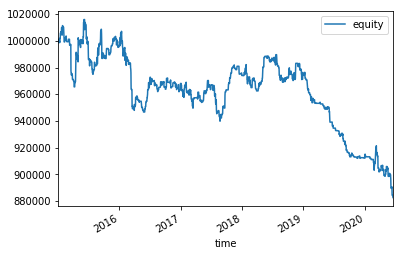

In [19]:
equity.drop('sample', axis=1).plot()
plt.show()

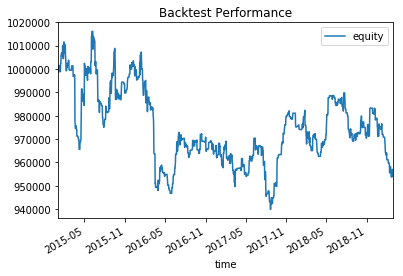

In [20]:
equity.loc[equity['sample'] == 'in sample'].drop('sample', axis=1).plot()
plt.title('Backtest Performance')
plt.show()

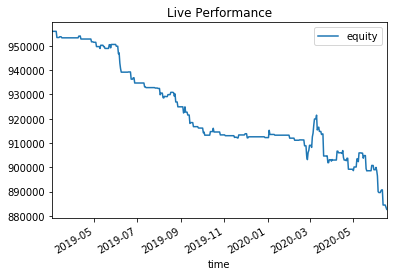

In [21]:
equity.loc[equity['sample'] == 'live trading'].drop('sample', axis=1).plot()
plt.title("Live Performance")
plt.show()

### 15. Create a conversation thread.
Start a conversation with the author(s) of the alpha via email. Quickly solve reconciliation issues or design automated filter questions.    

In [22]:
client.CreateConversation(
    alphaId = "d0fc88b1e6354fe95eb83225a",
    email = "you@your-company.com",
    message = "Hello World!",
    subject = "Alpha Conversation",
    cc = "bot1@your-company.com, bot2@your-company.com, bot2@your-company.com"
)

'Conversation thread was successfully created.'

### 16. Decode Symbol string.
Symbol represents a unique security identifier. This is made of two components, the unique SID and the Value. The value is the current ticker symbol while the SID is constant over the life of a security.
The SID contains information about a specific security. This includes the symbol and other data specific to the SecurityType.

In [23]:
from AlphaStream.Models import Symbol
string_symbols = ['SPY R735QTJ8XC9X', 'AAPL R735QTJ8XC9X', 'EURUSD 5O', 'USDJPY 8G', 'WTICOUSD 8I', 'BTCUSD XJ', 'ED XKDEAL18BYP5' ]
for string_symbol in string_symbols:
    symbol = Symbol(string_symbol)
    print(f'Ticker: {symbol.Symbol}. Market: {symbol.Market}. Security Type: {symbol.SecurityType}. Date: {symbol.Date}')

Ticker: SPY. Market: USA. Security Type: Equity. Date: 1998-01-02 00:00:00
Ticker: AAPL. Market: USA. Security Type: Equity. Date: 1998-01-02 00:00:00
Ticker: EURUSD. Market: FXCM. Security Type: Forex. Date: None
Ticker: USDJPY. Market: Oanda. Security Type: Forex. Date: None
Ticker: WTICOUSD. Market: Oanda. Security Type: Cfd. Date: None
Ticker: BTCUSD. Market: GDAX. Security Type: Crypto. Date: None
Ticker: ED. Market: USA. Security Type: Future. Date: 2020-12-15 00:00:00
